This notebook is a test to compare float grounding pressure with bathymetry products, on a specific region  
__author__ = 'kevin.balem@ifremer.fr'
Here's the 1st plan :
- Get float index
- Subset region of interest
- Get/Set floats url
- Xarray open if files exists, and preprocess at max
- Subset again region of interest
- Interp etopo at cycles positions
- Map both bathy and difference
- Stat it (deviationS, errors, ...)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import cmocean
from cartopy.geodesic import Geodesic
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import scipy.interpolate as interpolate
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')

In [6]:
ix = pd.read_csv('/home/ref-argo/gdac/ar_index_global_prof.txt', 
                 sep=',', index_col=None, header=0, skiprows=8,
                 names=['file','date','latitude','longitude','ocean','profiler_type','institution','update'], 
                 dtype={'file': np.unicode_, 'latitude': np.float32, 'longitude': np.float32, 'ocean': str , 'profiler_type': str , 'institution': str }
                )
ix.tail()

,file,date,latitude,longitude,ocean,profiler_type,institution,update
2888050,nmdis/2901633/profiles/R2901633_067.nc,2.013050e+13,27.462000,139.106995,P,841,NM,20130507103443
2888051,nmdis/2901633/profiles/R2901633_068.nc,2.013051e+13,27.431999,138.839996,P,841,NM,20130511165723
2888052,nmdis/2901633/profiles/R2901633_069.nc,2.013052e+13,27.691999,138.677002,P,841,NM,20130521170139
2888053,nmdis/2901633/profiles/R2901633_070.nc,2.013053e+13,27.895000,138.464996,P,841,NM,20130531181516
2888054,nmdis/2901633/profiles/R2901633_071.nc,2.013061e+13,27.931000,138.089996,P,841,NM,20130617181801


In [7]:
roi = np.array([-60.0,-21.0,45.0,63.0])
ixs = ix[(ix['latitude']>roi[2])&(ix['latitude']<roi[3]) & 
         (ix['longitude']>roi[0])&(ix['longitude']<roi[1])&
         ((ix['profiler_type']=='838'))]
#         ((ix['profiler_type']=='844')|(ix['profiler_type']=='838'))]
ixs = ixs.reset_index().drop(columns='index')

dacs = {'AO':'aoml','BO':'bodc','IF':'coriolis','HZ':'csio','CS':'csiro','IN':'incois','JA':'jma','KM':'kma','KO':'kordi','ME':'meds','NM':'nmdis'}
ixs['wmo']=[f.split('/')[1] for f in ixs['file']]
ixs['dac']=[dacs[f] for f in ixs['institution']]
ixs = ixs.groupby('wmo').max().reset_index()
ixs.tail()

,wmo,file,date,latitude,longitude,ocean,profiler_type,institution,update,dac
51,6903872,coriolis/6903872/profiles/R6903872_088.nc,2.023111e+13,62.889999,-29.974001,A,838,IF,20231108162756,coriolis
52,6903873,coriolis/6903873/profiles/R6903873_088.nc,2.023111e+13,62.416000,-37.743999,A,838,IF,20231110082748,coriolis
53,6990538,coriolis/6990538/profiles/R6990538_015.nc,2.023111e+13,53.595001,-24.912001,A,838,IF,20231112012603,coriolis
54,7901036,coriolis/7901036/profiles/R7901036_014.nc,2.023111e+13,60.032001,-40.911999,A,838,IF,20231112182936,coriolis
55,7901037,coriolis/7901037/profiles/R7901037_014.nc,2.023111e+13,59.846001,-37.972000,A,838,IF,20231111212540,coriolis


In [8]:
# HARD MODE, GROUNDING DURING DESCENT TO PROFILE DEPTH
df = xr.Dataset({"LATITUDE":(["N_PROF"],[]),"LONGITUDE": (["N_PROF"],[]),"WMO": (["N_PROF"],[]),"Zg": (["N_PROF"],[]), "Zp": (["N_PROF"],[])},coords={})
for i in range(len(ixs)):    
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"   
    urld="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_prof.nc"
    if (os.path.exists(urlt)):
        try:
            dt = xr.open_dataset(urlt)        
            cycles_grounded = np.argwhere(np.isin(dt['GROUNDED'].values.astype(str),['Y','P','B','C'])).T[0]
            try:
                grounded = dt['CYCLE_NUMBER_INDEX'].values[cycles_grounded]
            except KeyError:
                try:
                    grounded = dt['CYCLE_NUMBER_ACTUAL'].values[cycles_grounded]
                except KeyError:
                    grounded = []
        except:
            #print('issue on : '+urlt)
            pass
        if (len(grounded)>0):            
            try:
                dg = dt[['CYCLE_NUMBER','JULD','PRES']].where(dt['MEASUREMENT_CODE']==901.,drop=True).groupby('CYCLE_NUMBER').last()
                # GROUNDING DATE > PARKING DRIFT END ?
                # Here we make sure that grounding occurs in the descent to profile depth and not during parking drift. We do that comparing grounding time 
                # (meas code 901) and parking drift end (meas code 300)
                park_end = dt[['CYCLE_NUMBER','JULD']].where(dt['MEASUREMENT_CODE']==300.,drop=True)
                a = [(dg['JULD'][i].values - park_end['JULD'].where(park_end['CYCLE_NUMBER']==dg['CYCLE_NUMBER'][i],drop=True).values).astype(int)>0 
                     for i in range(len(dg['CYCLE_NUMBER'].values))]
                a = [a[i][0] for i in range(len(dg['CYCLE_NUMBER'].values))]
                dg['grd_on_prf'] = xr.DataArray(a, dims=['CYCLE_NUMBER'])
                dg = dg.where(dg['grd_on_prf']==True,drop=True)
                
                dd = xr.open_dataset(urld)
                # PROFILE DATA
                ds = dd.isel(N_PROF=dd['N_PROF'].values[np.isin(dd['CYCLE_NUMBER'].values,
                                                                dg['CYCLE_NUMBER'].values)])[['PRES','JULD','CYCLE_NUMBER',
                                                                                              'LATITUDE','LONGITUDE']].groupby('CYCLE_NUMBER').last()               
                # MAX PRES AND DEPTH CALCULATION for ds and dg
                ds = ds.max('N_LEVELS')
                ds['Z'] = -1*xr.DataArray(gsw.z_from_p(ds['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')
                dg['Z'] = -1*xr.DataArray(gsw.z_from_p(dg['PRES'],ds['LATITUDE']),dims='CYCLE_NUMBER')                
                
                dtmp = xr.Dataset({"LATITUDE":("N_PROF",ds['LATITUDE'].values),
                                   "LONGITUDE":("N_PROF",ds['LONGITUDE'].values),
                                   "WMO":("N_PROF",np.zeros_like(ds['LONGITUDE'].values)+int(ixs['wmo'][i])),
                                   "Zg": ("N_PROF",dg['Z'].values),
                                   "Zp": ("N_PROF",ds['Z'].values)},coords={})
                    
                df=xr.concat([df,dtmp],dim='N_PROF')
            except:
                #print('issue on : '+urld) 
                pass
df = df.where((df['LONGITUDE']>roi[0])&(df['LONGITUDE']<roi[1])&(df['LATITUDE']>roi[2])&(df['LATITUDE']<roi[3]),drop=True)
df = df.sortby('LONGITUDE')
print(df)

/export/home/anaconda3/envs/gmsl/lib/python3.9/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/export/home/anaconda3/envs/gmsl/lib/python3.9/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/export/home/anaconda3/envs/gmsl/lib/python3.9/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/export/home/anaconda3/envs/gmsl/lib/python3.9/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/export/home/anaconda3/envs/gmsl/lib/python3.9/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encounter

<xarray.Dataset>
Dimensions:    (N_PROF: 2755)
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float64 60.29 60.25 60.5 60.15 ... 51.51 51.18 57.73
    LONGITUDE  (N_PROF) float64 -59.91 -59.77 -59.72 ... -21.27 -21.2 -21.03
    WMO        (N_PROF) float64 6.903e+06 6.903e+06 ... 6.903e+06 6.903e+06
    Zg         (N_PROF) float64 2.174e+03 2.263e+03 ... 2.724e+03 2.454e+03
    Zp         (N_PROF) float64 2.172e+03 2.261e+03 ... 2.724e+03 2.453e+03


In [18]:
np.linspace(200,radius,10)

array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
       2000.])

In [19]:
# SPREAD BATHY : Array of random points around position to interpolate bathy
# INIT at 100m around points
PTS=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_PROF=i).values,
                                           lat=df['LATITUDE'].isel(N_PROF=i).values,
                                           radius=100.,
                                           n_samples=25)) for i in range(len(df['N_PROF']))])
# SPREAD 200-2000m around points
radius = 2000.0 #in meters
radrange  = np.linspace(200,radius,10)
for r in radrange:
    PT0=np.array([np.asarray(Geodesic().circle(lon=df['LONGITUDE'].isel(N_PROF=i).values,
                                               lat=df['LATITUDE'].isel(N_PROF=i).values,
                                               radius=r,
                                               n_samples=50)) for i in range(len(df['N_PROF']))])
    PTS = np.column_stack((PTS,PT0))

x=xr.DataArray(PTS[:,:,0],dims=['N_PROF','PTS'])
y=xr.DataArray(PTS[:,:,1],dims=['N_PROF','PTS'])
spread_bathy = xr.Dataset()
spread_bathy['etopo'] = -1*etopo.interp(x=x,y=y,method='linear')['z']
spread_bathy['gebco'] = -1*gebco.interp(lon=x,lat=y,method='linear')['elevation']
print(spread_bathy)

<xarray.Dataset>
Dimensions:  (N_PROF: 2755, PTS: 525)
Coordinates:
    x        (N_PROF, PTS) float64 -59.91 -59.91 -59.92 ... -21.02 -21.02 -21.03
    y        (N_PROF, PTS) float64 60.29 60.29 60.29 60.29 ... 57.75 57.75 57.75
    lon      (N_PROF, PTS) float64 -59.91 -59.91 -59.92 ... -21.02 -21.02 -21.03
    lat      (N_PROF, PTS) float64 60.29 60.29 60.29 60.29 ... 57.75 57.75 57.75
Dimensions without coordinates: N_PROF, PTS
Data variables:
    etopo    (N_PROF, PTS) float64 2.192e+03 2.191e+03 ... 2.483e+03 2.488e+03
    gebco    (N_PROF, PTS) float64 2.192e+03 2.192e+03 ... 2.548e+03 2.549e+03


### What's the spread ?
That's the interpolation of gebco or etopo depth inside a circle around the profile lat/lon.  
I find it easier than searching for min/max inside that same circle

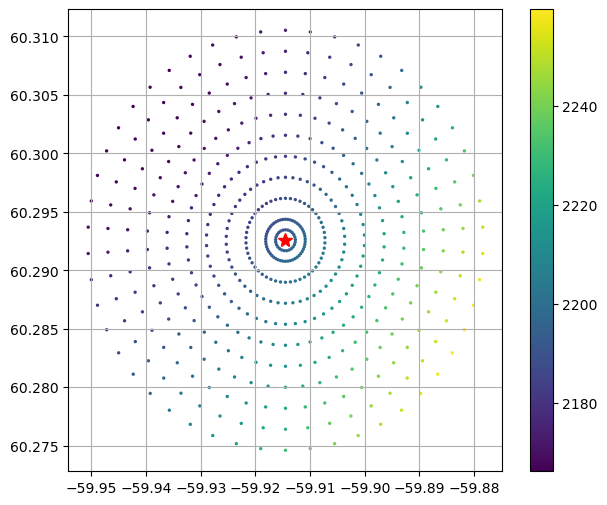

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(df['LONGITUDE'].isel(N_PROF=0),df['LATITUDE'].isel(N_PROF=0),'*r',markersize=10.)
plt.scatter(spread_bathy['lon'].isel(N_PROF=0),spread_bathy['lat'].isel(N_PROF=0),c=spread_bathy['gebco'].isel(N_PROF=0),s=2.)
plt.colorbar()

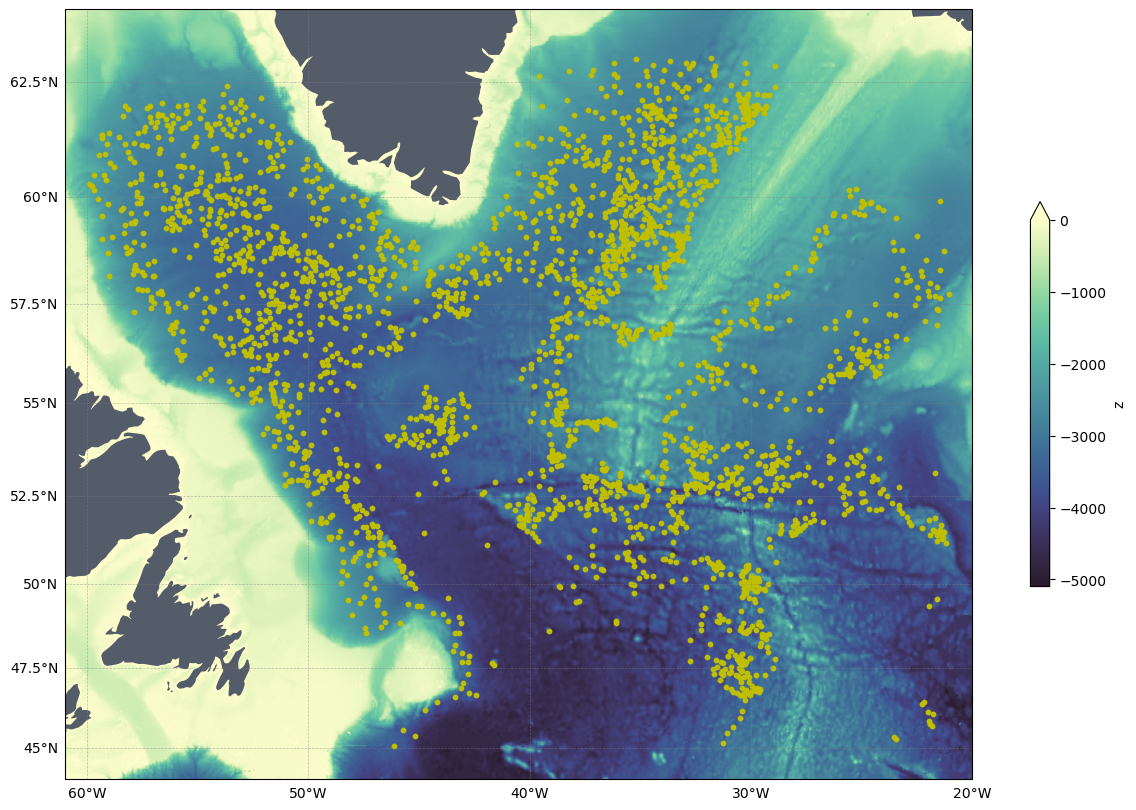

In [ ]:
fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

etopo.where((etopo['x']>roi[0]-1)&(etopo['x']<roi[1]+1)&(etopo['y']>roi[2]-1)&(etopo['y']<roi[3]+1),drop=True)['z'].plot(
    vmax=0,cmap=cmocean.cm.deep_r, cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())

ax.scatter(df['LONGITUDE'],df['LATITUDE'],s=10,c='y',transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

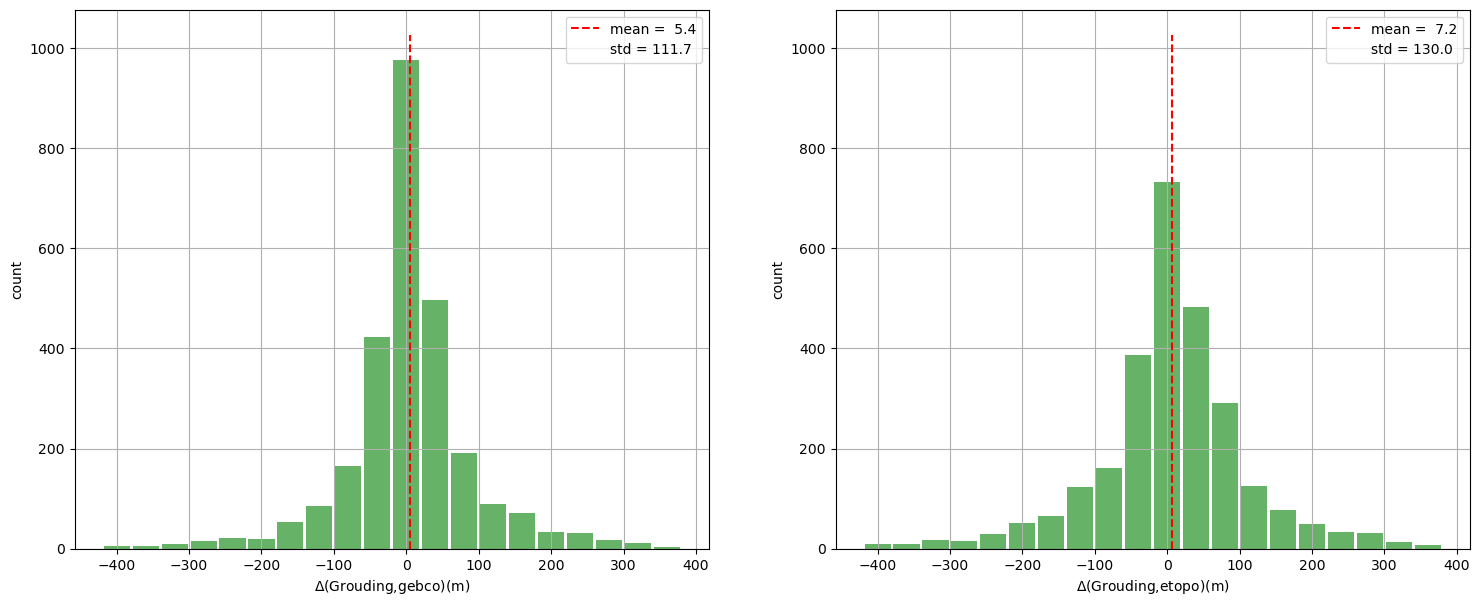

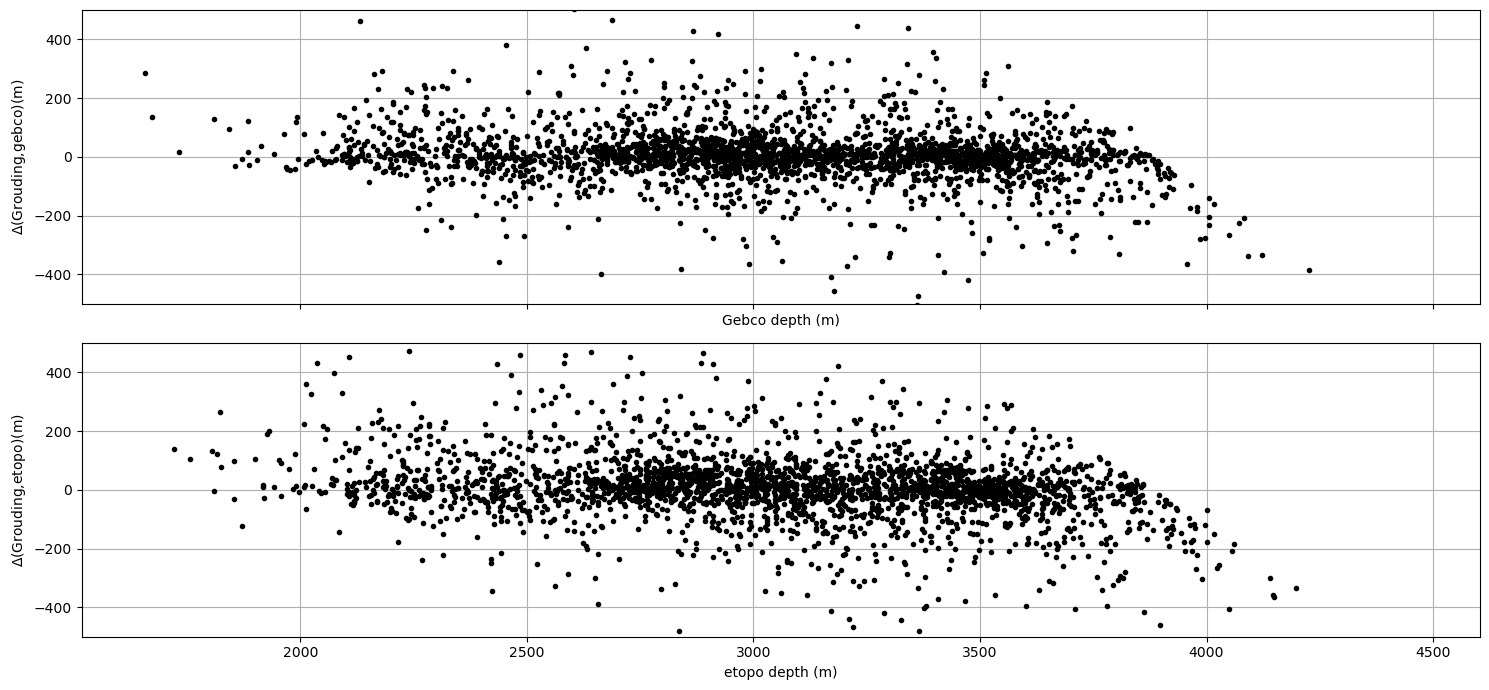

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,7),sharex=True)

data0 = (df['Zg'].values - spread_bathy['gebco'].mean('PTS')).values
ax[0].hist(data0, bins=np.arange(-420,420,40), density=False, alpha=0.6, color='g',rwidth=0.9)
ax[0].set_xlabel(r'$\Delta$(Grouding,gebco)(m)')
ax[0].set_ylabel('count')
yl=ax[0].get_ylim()
a=ax[0].vlines(np.mean(data0),yl[0],yl[1],color='r',linestyle='--',label='mean = '+"{:4.1f}".format(np.mean(data0)))
b=ax[0].vlines(np.std(data0),yl[0],yl[1],color='b',linewidth=0,label='std = '+"{:4.1f}".format(np.std(data0)))
ax[0].legend(handles=[a,b])

data1 = (df['Zg'].values - spread_bathy['etopo'].mean('PTS')).values
ax[1].hist(data1, bins=np.arange(-420,420,40), density=False, alpha=0.6, color='g',rwidth=0.9)
ax[1].set_xlabel(r'$\Delta$(Grouding,etopo)(m)')
ax[1].set_ylabel('count')
a=ax[1].vlines(np.mean(data1),yl[0],yl[1],color='r',linestyle='--',label='mean = '+"{:4.1f}".format(np.mean(data1)))
b=ax[1].vlines(np.std(data1),yl[0],yl[1],color='b',linewidth=0,label='std = '+"{:4.1f}".format(np.std(data1)))
ax[1].legend(handles=[a,b])

fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
ax[0].plot(spread_bathy['gebco'].mean('PTS'),df['Zg'].values - spread_bathy['gebco'].mean('PTS'),'k.')
ax[0].set_ylim(-500,500)
ax[0].set_ylabel(r'$\Delta$(Grouding,gebco)(m)')
ax[0].set_xlabel('Gebco depth (m)')                 
    
ax[1].plot(spread_bathy['etopo'].mean('PTS'),df['Zg'].values - spread_bathy['etopo'].mean('PTS'),'k.')
ax[1].set_ylim(-500,500)
ax[1].set_ylabel(r'$\Delta$(Grouding,etopo)(m)')
ax[1].set_xlabel('etopo depth (m)')   

plt.tight_layout()